In [ ]:
from google.colab import drive 
drive.mount('/saurabh' , force_remount = True)

Mounted at /saurabh


Importing Libraries

In [ ]:
import os
import statistics
import csv
import itertools
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import seaborn as sns
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

# To create interactive plots
import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

#import optuna 
#print('Optuna', optuna.__version__)

#from optkeras.optkeras import OptKeras
#import optkeras
#print('OptKeras', optkeras.__version__)

# (Optional) Disable messages from Optuna below WARN level.
#optuna.logging.set_verbosity(optuna.logging.WARN)

# **Pre-Processing (Some parts of code adapted from https://github.com/LACoderDeBH/CS230_HAR_WISDM/blob/master/Phone_derek.ipynb)**

In [ ]:
cd /saurabh/My Drive/Datasets/har/wisdm-dataset/raw/

/saurabh/My Drive/Datasets/har/wisdm-dataset/raw


In [ ]:
ls

data/                 HAR_Simple_model_000000.h5  model_plot.png  watch/
HAR_Simple_Keras.csv  HAR_Simple_Optuna.csv       phone/


In [ ]:
data_dir = '/saurabh/My Drive/Datasets/har/wisdm-dataset/raw'
phone_data = os.path.join(data_dir, 'phone')
watch_data = os.path.join(data_dir, 'watch')

In [ ]:
p_base = os.path.join(phone_data , 'accel')

In [ ]:
os.listdir(p_base)

['data_1612_accel_phone.txt',
 'data_1609_accel_phone.txt',
 'data_1610_accel_phone.txt',
 'data_1616_accel_phone.txt',
 'data_1613_accel_phone.txt',
 'data_1603_accel_phone.txt',
 'data_1607_accel_phone.txt',
 'data_1602_accel_phone.txt',
 'data_1614_accel_phone.txt',
 'data_1601_accel_phone.txt',
 'data_1615_accel_phone.txt',
 'data_1605_accel_phone.txt',
 'data_1606_accel_phone.txt',
 'data_1600_accel_phone.txt',
 'data_1608_accel_phone.txt',
 'data_1604_accel_phone.txt',
 'data_1611_accel_phone.txt',
 'data_1625_accel_phone.txt',
 'data_1628_accel_phone.txt',
 'data_1629_accel_phone.txt',
 'data_1635_accel_phone.txt',
 'data_1622_accel_phone.txt',
 'data_1637_accel_phone.txt',
 'data_1630_accel_phone.txt',
 'data_1632_accel_phone.txt',
 'data_1631_accel_phone.txt',
 'data_1636_accel_phone.txt',
 'data_1627_accel_phone.txt',
 'data_1634_accel_phone.txt',
 'data_1619_accel_phone.txt',
 'data_1633_accel_phone.txt',
 'data_1620_accel_phone.txt',
 'data_1624_accel_phone.txt',
 'data_161

In [ ]:
participants = [p.replace('_accel_phone.txt', '') for p in os.listdir(p_base) if p.startswith('data_')]

In [ ]:
participants

['data_1612',
 'data_1609',
 'data_1610',
 'data_1616',
 'data_1613',
 'data_1603',
 'data_1607',
 'data_1602',
 'data_1614',
 'data_1601',
 'data_1615',
 'data_1605',
 'data_1606',
 'data_1600',
 'data_1608',
 'data_1604',
 'data_1611',
 'data_1625',
 'data_1628',
 'data_1629',
 'data_1635',
 'data_1622',
 'data_1637',
 'data_1630',
 'data_1632',
 'data_1631',
 'data_1636',
 'data_1627',
 'data_1634',
 'data_1619',
 'data_1633',
 'data_1620',
 'data_1624',
 'data_1617',
 'data_1618',
 'data_1626',
 'data_1621',
 'data_1623',
 'data_1643',
 'data_1648',
 'data_1650',
 'data_1649',
 'data_1641',
 'data_1644',
 'data_1639',
 'data_1647',
 'data_1640',
 'data_1646',
 'data_1638',
 'data_1645',
 'data_1642']

## **Data Cleaning - Merging the flat file to create 2 datasets , Phone and Watch**
---



In [ ]:
def sanitize_data(data):
    data['z'] = data['z'].apply(lambda x: x.replace(';',''))
    data[['x', 'y', 'z']] = data[['x', 'y', 'z']].astype(float)

combined_phone = []
combined_watch = []
for participant in tqdm(participants):
    data_types = itertools.product(['phone', 'watch'], ['accel', 'gyro'])
    phone_data = []
    watch_data = []
    for device, sensor in data_types:
        data_path = f'{participant}_{sensor}_{device}.txt'
        data = pd.read_csv(os.path.join(data_dir, device, sensor, data_path), header=None, names=['participant', 'activity', 't', 'x', 'y', 'z'])  
        sanitize_data(data)
        data = data.rename(columns={'x': f'{device}_{sensor}_x', 'y': f'{device}_{sensor}_y', 'z': f'{device}_{sensor}_z'})
        data = data.sort_values('t')
        l = phone_data if device == 'phone' else watch_data
        l.append(data)
    merged_phone = pd.merge_asof(phone_data[0], phone_data[1], on='t', by=['participant', 'activity'])
    merged_phone = merged_phone[~merged_phone.isnull().any(axis=1)].reset_index(drop=True)
    combined_phone.append(merged_phone)
    merged_watch = pd.merge_asof(watch_data[0], watch_data[1], on='t', by=['participant', 'activity'])
    merged_watch = merged_watch[~merged_watch.isnull().any(axis=1)].reset_index(drop=True)
    combined_watch.append(merged_watch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
phone = pd.concat(combined_phone)
watch = pd.concat(combined_watch)

In [ ]:
phone.to_pickle('phone.df')
watch.to_pickle('watch.df')

## **Checking the shape of Phone and Watch dataset**

---



In [ ]:
print("Watch " ,watch.shape)
print("Phone " ,phone.shape)

Watch  (3731135, 9)
Phone  (4780251, 9)


## **Checking few rows of Phone and Watch dataset**

In [ ]:
phone.head()

participant activity  ...  phone_gyro_y  phone_gyro_z
0         1612        B  ...      3.817078     -0.845810
1         1612        B  ...     -4.211731      2.406220
2         1612        B  ...      0.172501      4.049133
3         1612        B  ...      0.917297      5.440033
4         1612        B  ...      0.853439      5.756485

[5 rows x 9 columns]

In [ ]:
watch.head()

participant activity  ...  watch_gyro_y  watch_gyro_z
0         1612        B  ...      3.018782      6.615122
1         1612        B  ...      3.407604      7.950964
2         1612        B  ...      2.568176      7.188234
3         1612        B  ...      1.420886      4.900046
4         1612        B  ...     -0.787407      2.617185

[5 rows x 9 columns]

## **Checking the datatype of Phone & Watch dataset**

In [ ]:
print(phone.dtypes)
print("**************")
print(watch.dtypes)

participant        int64
activity          object
t                  int64
phone_accel_x    float64
phone_accel_y    float64
phone_accel_z    float64
phone_gyro_x     float64
phone_gyro_y     float64
phone_gyro_z     float64
dtype: object
**************
participant        int64
activity          object
t                  int64
watch_accel_x    float64
watch_accel_y    float64
watch_accel_z    float64
watch_gyro_x     float64
watch_gyro_y     float64
watch_gyro_z     float64
dtype: object


## **Creating a mapping of the various activities in WISDM Dataset**

In [ ]:
activties_map = {
    'A': 'walking',
    'B': 'jogging',
    'C': 'stairs',
    'D': 'sitting',
    'E': 'standing',
    'F': 'typing',
    'G': 'teeth',
    'H': 'soup',
    'I': 'chips',
    'J': 'pasta',
    'K': 'drinking',
    'L': 'sandwich',
    'M': 'kicking',
    'O': 'catch',
    'P': 'dribbling',
    'Q': 'writing',
    'R': 'clapping',
    'S': 'folding'
}

# **EDA**

## **Checking for Class Imbalance in various Activities in Watch and Phone Dataset**

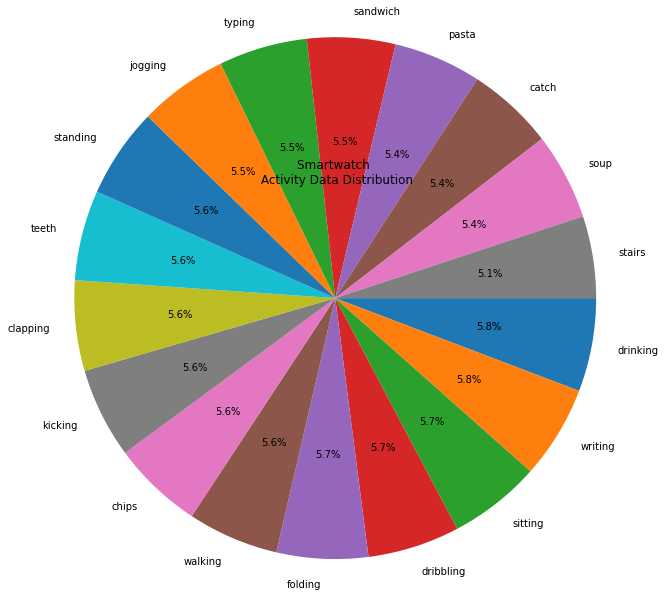

In [ ]:
temp = watch.activity.value_counts()
values = temp.values
labels = list(temp.index)

labels = [activties_map[label] for label in labels]

plt.pie(values, labels=labels, autopct='%1.1f%%',counterclock=False, radius=3)
plt.title('Smartwatch \n Activity Data Distribution')
plt.show()
# Visualizing the activity data

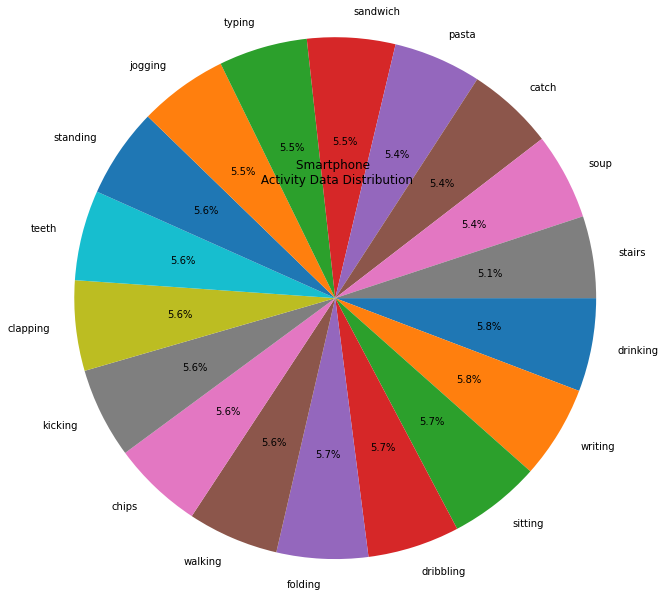

In [ ]:
temp1 = phone.activity.value_counts()
values = temp.values
labels = list(temp.index)

labels = [activties_map[label] for label in labels]

plt.pie(values, labels=labels, autopct='%1.1f%%',counterclock=False, radius=3)
plt.title('Smartphone \n Activity Data Distribution')
plt.show()
# Visualizing the activity data

### **From the above pie charts it can be concluded that class imabalalnce is not there and the datasets are balanced**"

## **Checking the distribution of count of activities per subject**"

<BarContainer object of 51 artists>

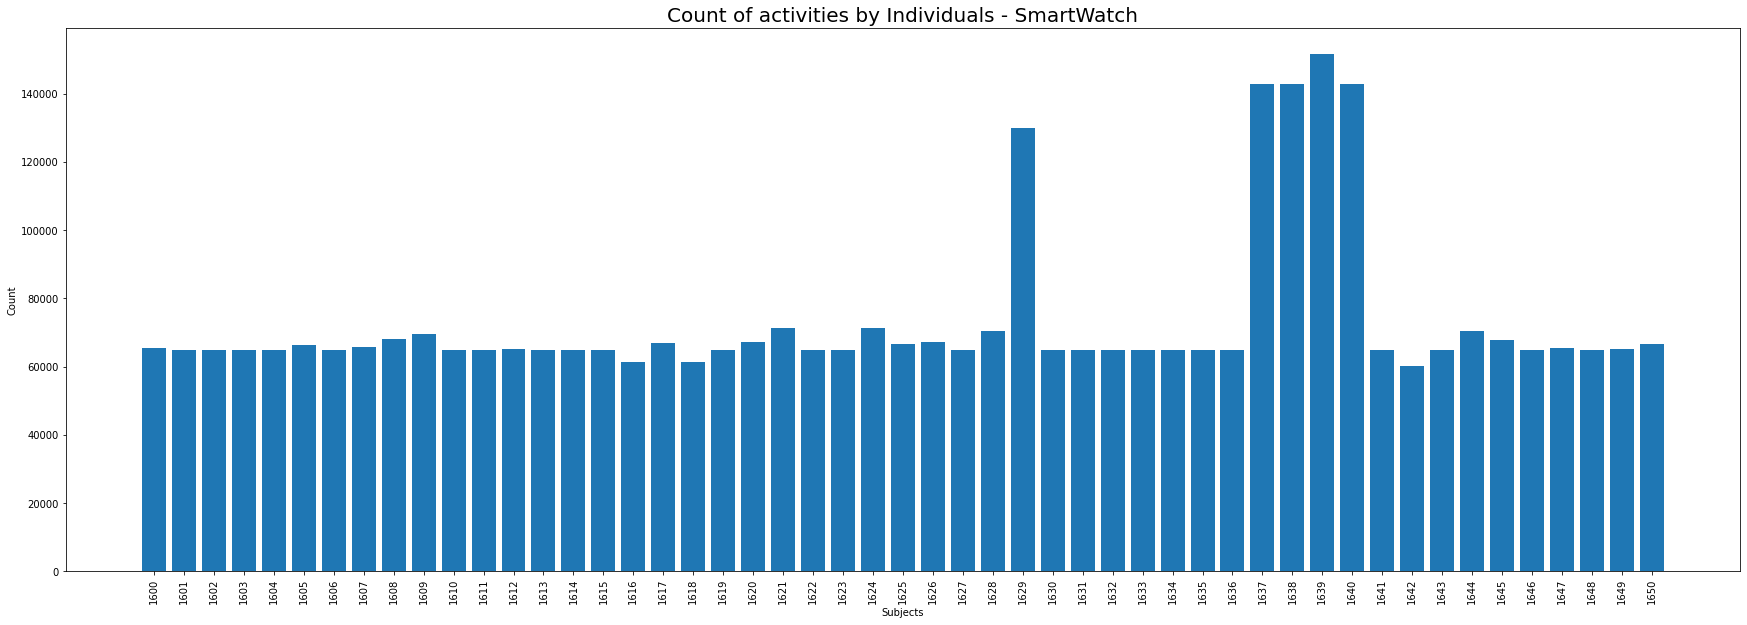

In [ ]:
temp = watch['participant'].value_counts()
values = temp.values
labels = list(temp.index)
plt.figure(figsize=(30,10))
plt.xticks(labels , rotation = 90)
plt.xlabel('Subjects', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of activities by Individuals - SmartWatch', fontsize=20)
plt.bar(labels, values)

<BarContainer object of 51 artists>

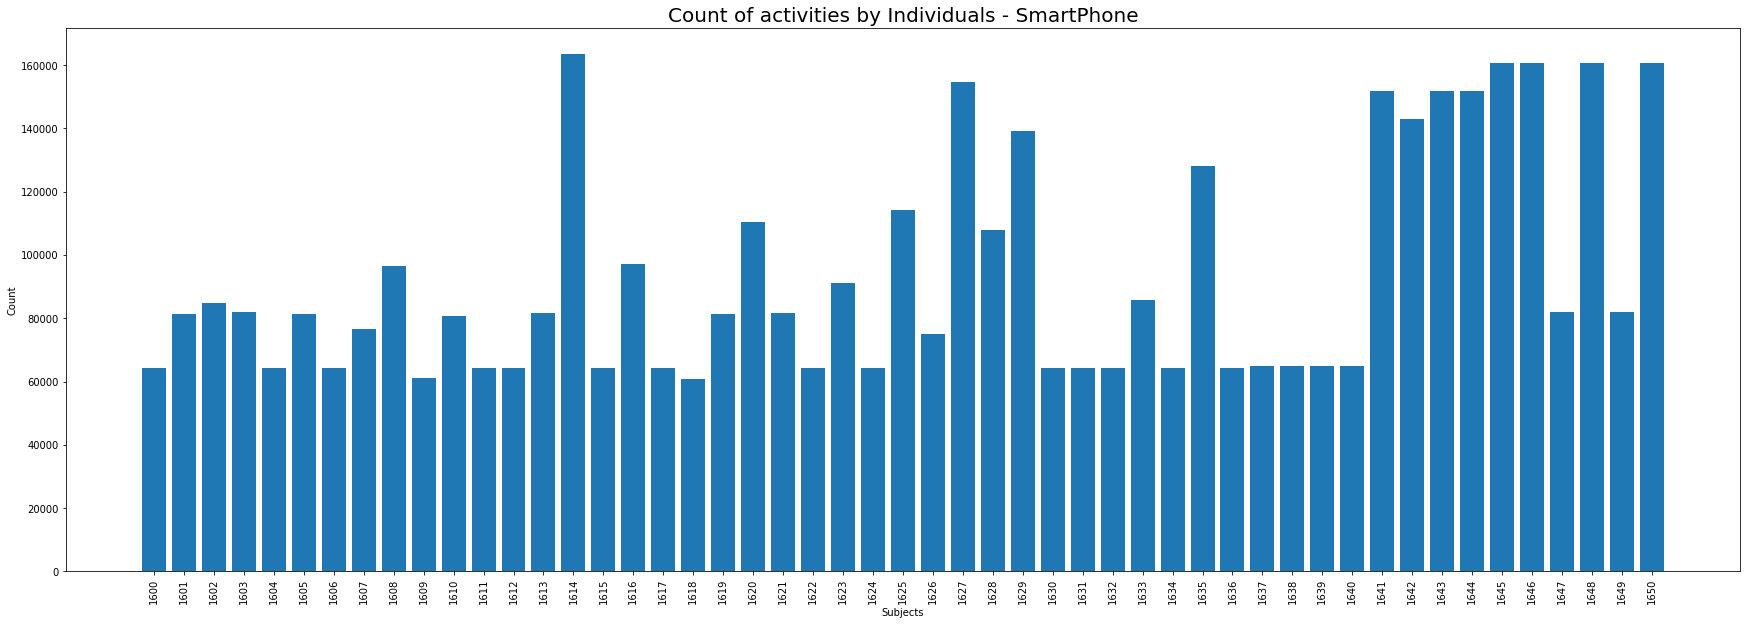

In [ ]:
temp = phone['participant'].value_counts()
values = temp.values
labels = list(temp.index)
plt.figure(figsize=(30,10))
plt.xticks(labels , rotation = 90)
plt.xlabel('Subjects', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Count of activities by Individuals - SmartPhone', fontsize=20)
plt.bar(labels, values)

## **Checking is all subjects are contributing to 18 activites in watch and phone dataset**"

In [ ]:
g_watch = watch.groupby('participant')['activity'].nunique()

In [ ]:
g_watch = g_watch.reset_index()

In [ ]:
g_watch[g_watch['activity'] < 18]

participant  activity
16         1616        17
18         1618        17
37         1637        16
38         1638        16
39         1639        17
40         1640        16
42         1642        16

## **From above it can be inferred that 7 subjects - 1616, 1618, 1637, 1638, 1639, 1640, and 1642 did not contain all pre-defined 18 activities in watch dataset.**

In [ ]:
g_phone = phone.groupby('participant')['activity'].nunique()

In [ ]:
g_phone = g_phone.reset_index()

In [ ]:
g_phone[g_phone['activity'] < 18]

participant  activity
7          1607        17
9          1609        17
16         1616        16
18         1618        17
41         1641        17
42         1642        16
43         1643        17
44         1644        17

## **From above it can be inferred that 8 subjects - 1607, 1609, 1616, 1618, 1641, 1642, 643 , 1644 did not contain all pre-defined 18 activities in phone dataset.**

# **Creating a mapping of 18 original activities into 3 Groups**
## **Ambulation activities:{walking,jogging, stairs, standing, kicking}**
## **Hand-oriented activities (General):{dribbling, playing catch, typing, writing, clapping,brushing teeth, folding clothes}**
## **Hand-oriented activities (eating):{eating,pasta, eating soup, eating sandwich, eating chips, drinking}**

In [ ]:
def activity_mapper(activity):
    if(activity in ['A', 'B', 'C', 'D', 'E', 'M']):
        return 0
    elif(activity in ['P', 'O', 'F', 'Q', 'R','G', 'S']):
        return 1
    else:
        return 2
phone['activity'] = phone['activity'].apply(activity_mapper)

In [ ]:
watch['activity'] = watch['activity'].apply(activity_mapper)

In [ ]:
activity_map = {
    0: 'Ambulation Oriented',
    1: 'Hand Oriented General',
    2: 'Hand Oriented Eating'
}

In [ ]:
activities = sorted(activity_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}


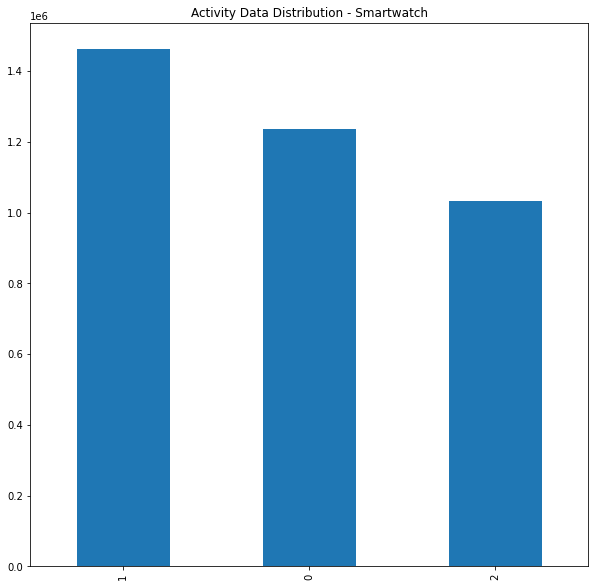

In [ ]:
watch.activity.value_counts().plot(kind = 'bar' , figsize=(10,10) , title ='Activity Data Distribution - Smartwatch')


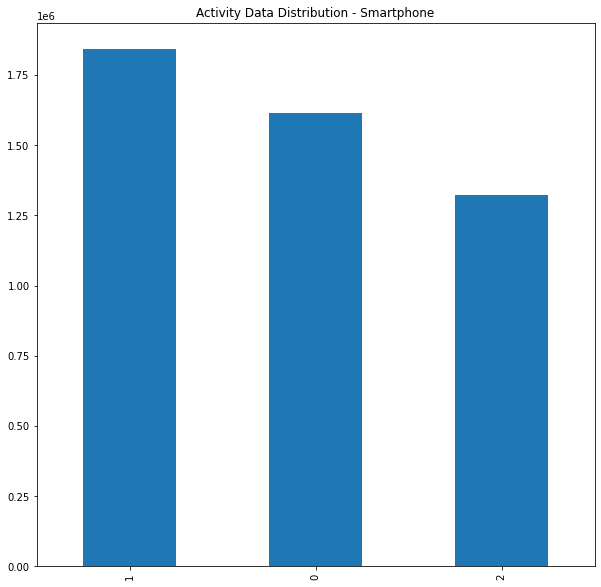

In [ ]:
phone.activity.value_counts().plot(kind = 'bar' , figsize=(10,10) , title ='Activity Data Distribution - Smartphone')

## **Plotting the sensor data for gyroscope and accelerometer for various actvity groups**

1.   List item
2.   List item



In [ ]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['watch_accel_x', 'watch_accel_y', 'watch_accel_z','watch_gyro_x','watch_gyro_y','watch_gyro_z']][:1000]
    plt.rcParams["figure.figsize"] = (10,6)
    axis = data.plot(subplots=False, figsize=(16, 12), 
                     title=activity)
    #axis.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

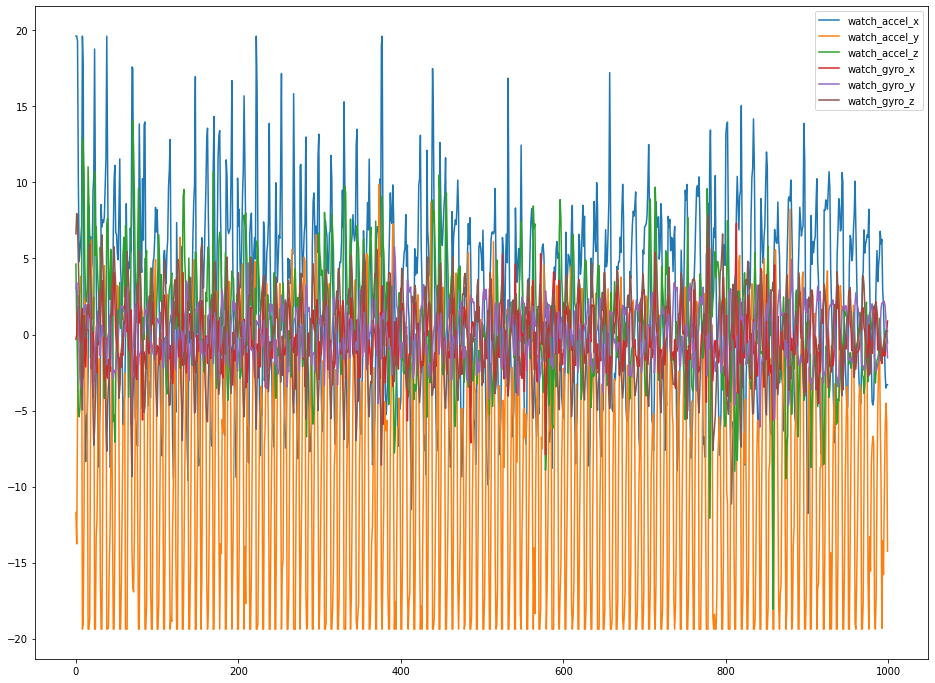

In [ ]:
plot_activity(0, watch)

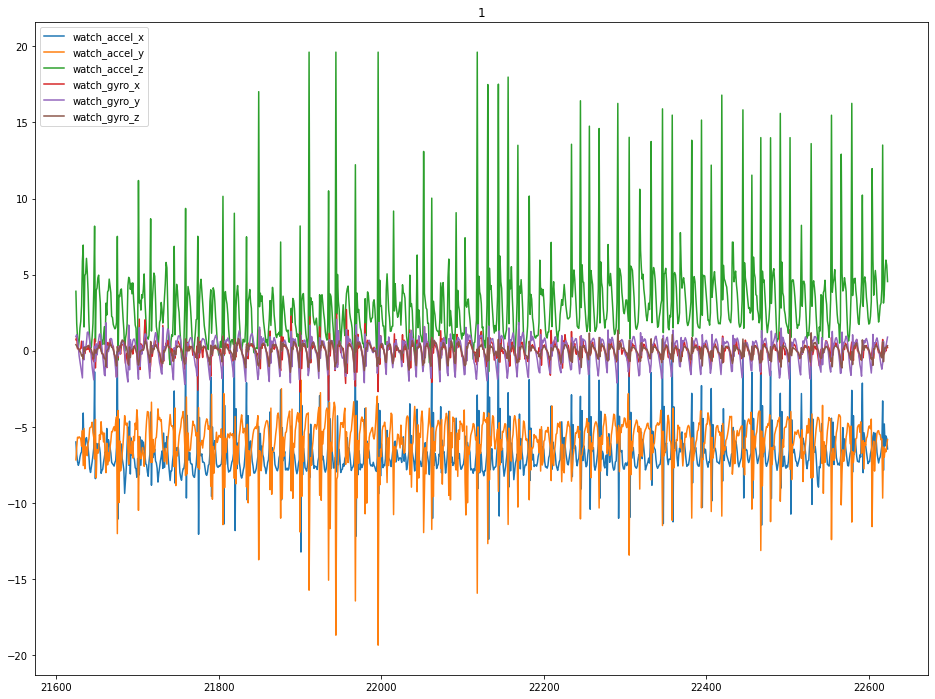

In [ ]:
plot_activity(1, watch)

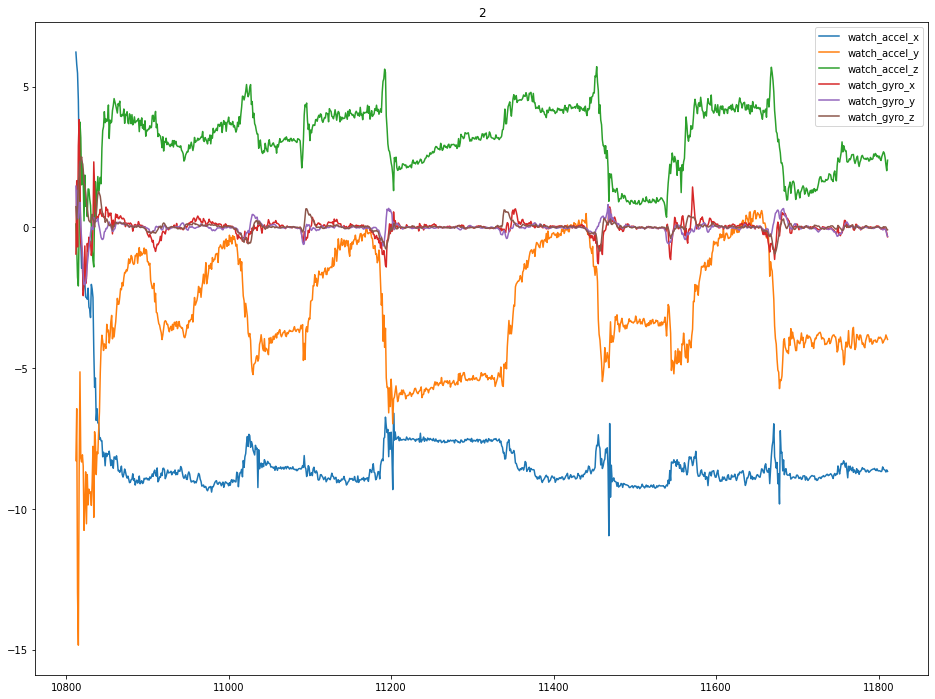

In [ ]:
plot_activity(2, watch)

In [ ]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['phone_accel_x', 'phone_accel_y', 'phone_accel_z','phone_gyro_x','phone_gyro_y','phone_gyro_z']][:1000]
    plt.rcParams["figure.figsize"] = (10,6)
    axis = data.plot(subplots=False, figsize=(16, 12), 
                     title=activity)
    #axis.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

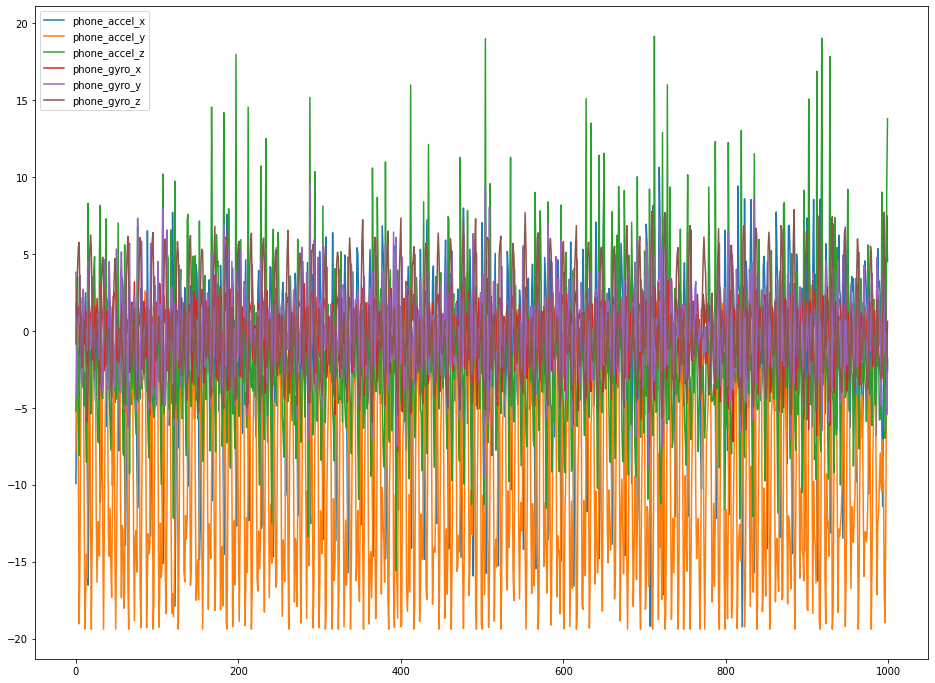

In [ ]:
plot_activity(0, phone)

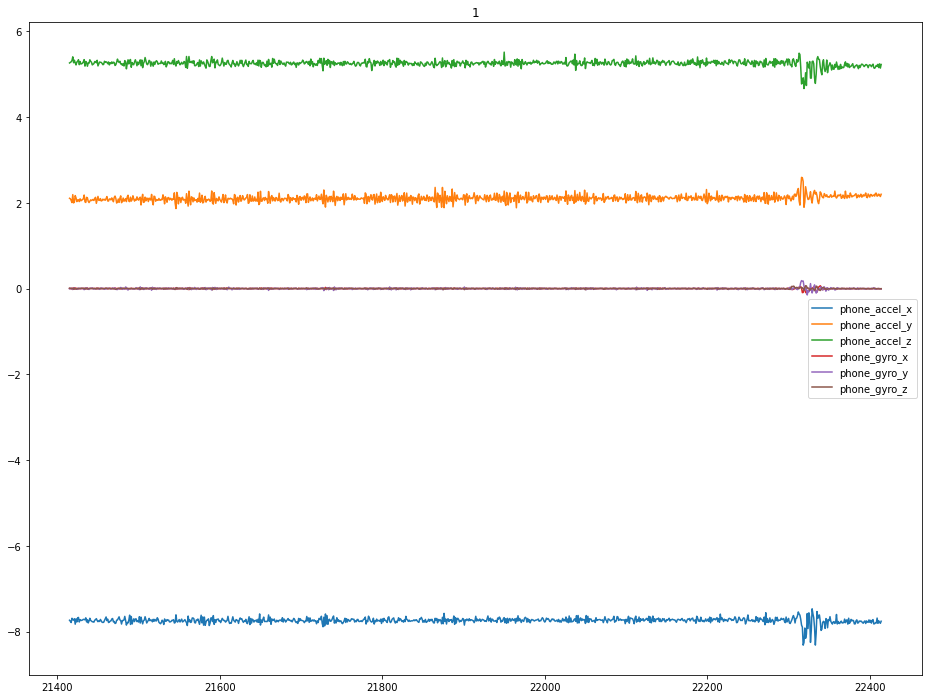

In [ ]:
plot_activity(1, phone)

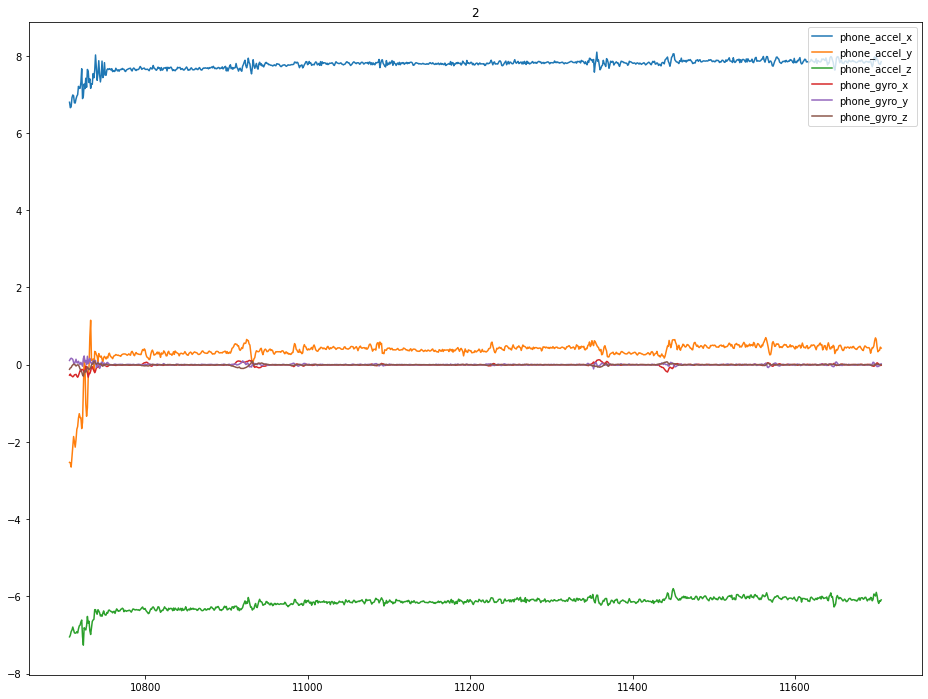

In [ ]:
plot_activity(2, phone)